In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

import vrpSolver

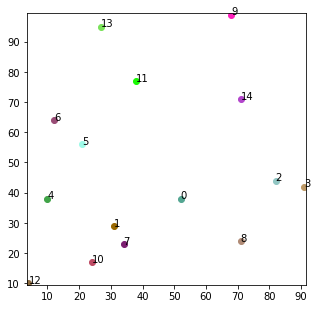

In [2]:
# Generate instance
nodes = vrpSolver.rndPlainNodes(N = 15)
fig, ax = vrpSolver.plotNodes(
    nodes = nodes)

In [3]:
# DFJ with lazy cut
DFJ_Lazy = vrpSolver.ipTSP(
    nodes = nodes, 
    fml = "DFJ_Lazy",
    timeLimit = 300)
print(DFJ_Lazy)

Academic license - for non-commercial use only
{'ofv': 332.5805287693271, 'seq': [0, 8, 3, 2, 14, 9, 13, 11, 6, 5, 4, 12, 10, 7, 1, 0], 'gap': 0, 'lowerBound': 332.5805287693271, 'upperBound': 332.5805287693271, 'runtime': 0.0050258636474609375, 'fml': 'DFJ_Lazy'}


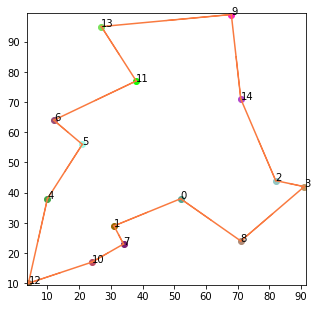

In [4]:
# Plot the result of TSP
vrpSolver.plotSeq(
    fig = fig,
    ax = ax,
    nodes=nodes, 
    seq=DFJ_Lazy['seq'])
fig

In [5]:
# DFJ with plain loop
DFJ_PlainLoop = vrpSolver.ipTSP(
    nodes = nodes, 
    fml = "DFJ_PlainLoop",
    timeLimit = 300)
print(DFJ_PlainLoop)

{'ofv': 332.58052876932715, 'seq': [0, 1, 7, 10, 12, 4, 5, 6, 11, 13, 9, 14, 2, 3, 8, 0], 'gap': 0, 'lowerBound': 332.58052876932715, 'upperBound': 332.58052876932715, 'runtime': 0.0030002593994140625, 'fml': 'DFJ_PlainLoop'}


In [6]:
# MTZ
MTZ = vrpSolver.ipTSP(
    nodes = nodes, 
    fml = "MTZ",
    timeLimit = 300)
print(MTZ)

{'ofv': 332.58052876932715, 'seq': [0, 1, 7, 10, 12, 4, 5, 6, 11, 13, 9, 14, 2, 3, 8, 0], 'gap': 0, 'lowerBound': 332.58052876932715, 'upperBound': 332.58052876932715, 'runtime': 0.016998291015625, 'fml': 'MTZ'}


In [7]:
# MultiCommodityFlow
MultiCommodityFlow = vrpSolver.ipTSP(
    nodes = nodes, 
    fml = "MultiCommodityFlow",
    timeLimit = 300)
print(MultiCommodityFlow)

{'ofv': 332.5805287693271, 'seq': [0, 8, 3, 2, 14, 9, 13, 11, 6, 5, 4, 12, 10, 7, 1, 0], 'gap': 0, 'lowerBound': 332.5805287693271, 'upperBound': 332.5805287693271, 'runtime': 0.06600189208984375, 'fml': 'MultiCommodityFlow'}


In [8]:
# ShortestPath
ShortestPath = vrpSolver.ipTSP(
    nodes = nodes, 
    fml = "ShortestPath",
    timeLimit = 300)
print(ShortestPath)

{'ofv': 332.58052876932715, 'seq': [0, 1, 7, 10, 12, 4, 5, 6, 11, 13, 9, 14, 2, 3, 8, 0], 'gap': 0, 'lowerBound': 332.58052876932715, 'upperBound': 332.58052876932715, 'runtime': 0.1600017547607422, 'fml': 'ShortestPath'}


In [9]:
# QAP
QAP = vrpSolver.ipTSP(
    nodes = nodes, 
    fml = "QAP",
    timeLimit = 300)
print(QAP)

{'ofv': None, 'seq': [], 'gap': 0.5539756907219155, 'lowerBound': 148.33900062367923, 'upperBound': 332.58052876932715, 'runtime': 300.1244945526123, 'fml': 'QAP'}
